In [1]:
import numpy as np
from openfermion.ops.operators import FermionOperator
from openfermion.linalg import get_number_preserving_sparse_operator
import scipy

### Operator Creation from scratch

Creates operators from first principles. Have been checked against the pyvqe output file

In [2]:
def k(p, q):
    pq = FermionOperator("[{}^ {}]".format(q, p)) - FermionOperator("[{}^ {}]".format(p, q))
    return pq


def d(a,b,c,d):
    abcd = FermionOperator("[{}^ {}^ {} {}]".format(a,b,c,d)) - FermionOperator("[{}^ {}^ {} {}]".format(c,d,a,b))
    return abcd


# preparation for fermionoperator
op = []

for p in range(4,-1,-2):
    for q in range(6,p,-2):
        op.append(k(p,q) + k(p+1,q+1))

for p in range(4,-1,-2):
    for q in range(6,p,-2):
        op.append(d(p+1,p,q+1,q))

for i, op_i in enumerate(op):
    print("Operator", i+1)
    print(op_i)

# Output visually checked to be identical to pyvqe output log

Operator 1
-1.0 [4^ 6] +
-1.0 [5^ 7] +
1.0 [6^ 4] +
1.0 [7^ 5]
Operator 2
-1.0 [2^ 6] +
-1.0 [3^ 7] +
1.0 [6^ 2] +
1.0 [7^ 3]
Operator 3
-1.0 [2^ 4] +
-1.0 [3^ 5] +
1.0 [4^ 2] +
1.0 [5^ 3]
Operator 4
-1.0 [0^ 6] +
-1.0 [1^ 7] +
1.0 [6^ 0] +
1.0 [7^ 1]
Operator 5
-1.0 [0^ 4] +
-1.0 [1^ 5] +
1.0 [4^ 0] +
1.0 [5^ 1]
Operator 6
-1.0 [0^ 2] +
-1.0 [1^ 3] +
1.0 [2^ 0] +
1.0 [3^ 1]
Operator 7
1.0 [5^ 4^ 7 6] +
-1.0 [7^ 6^ 5 4]
Operator 8
1.0 [3^ 2^ 7 6] +
-1.0 [7^ 6^ 3 2]
Operator 9
1.0 [3^ 2^ 5 4] +
-1.0 [5^ 4^ 3 2]
Operator 10
1.0 [1^ 0^ 7 6] +
-1.0 [7^ 6^ 1 0]
Operator 11
1.0 [1^ 0^ 5 4] +
-1.0 [5^ 4^ 1 0]
Operator 12
1.0 [1^ 0^ 3 2] +
-1.0 [3^ 2^ 1 0]


In [3]:
op_m = []
# transfer operator to matrix
for i in range(len(op)):
    op_m.append(
        get_number_preserving_sparse_operator(
            op[i], 8, 4,
            spin_preserving=True
            ).toarray()
        )

### Operators from opmat file
To compare against and verify the above

In [4]:
input_directory = r'C:\Users\Alice Ling\Desktop\Summer intern\Coding\replicating energies/H4_linear'

with open(input_directory + '/opmat', 'r') as f:
    op2 = f.readlines()

for i in range(len(op2)):
    op2[i] = int(op2[i].replace('\n', ''))

op2 = np.array(op2).reshape([36, 36, 12], order='F')
#what is op2 here? is it the operator matrix used in the file?

op_m2 = []
for i in range(12):
    op_m2.append(op2[:,:,i])

op_m2 = np.array(op_m2)


op_m and op_m2 are now equal

In [5]:
np.sum(np.abs(op_m - op_m2))

0.0

### Oporder, lowest, ref, ham

In [6]:
# DISCO Solution - hardcoded for speed

operator_sequence = np.array([11, 5, 2, 10, 11, 5, 2, 7, 1, 9, 12, 6, 7, 8])
coefficients = np.array([
    2.917352889,
    0.8948483047,
    -1.186780531,
    -1.385093655,
    2.806014218,
    0.9223849545,
    2.713723378,
    0.2087934190,
    2.356194490,
    -3.141592654,
    -1.435265476,
    1.640329124,
    -2.356194490,
    1.698202866
])

operator_sequence = operator_sequence[::-1]
coefficients = coefficients[::-1]

print(operator_sequence)
print(coefficients)

# Reference state
reference_state = np.zeros(36)
reference_state[0] = 1.0

# Hamiltonian input
ham = np.fromfile(input_directory + '/ham')
ham = np.reshape(ham,[36,36])

[ 8  7  6 12  9  1  7  2  5 11 10  2  5 11]
[ 1.69820287 -2.35619449  1.64032912 -1.43526548 -3.14159265  2.35619449
  0.20879342  2.71372338  0.92238495  2.80601422 -1.38509365 -1.18678053
  0.8948483   2.91735289]


### Calculate exponential

In [16]:
current_state = reference_state

for ind, op_i in enumerate(operator_sequence):
    op_i -= 1    
    operator_matrix = coefficients[ind] * op_m[op_i-1]
    operator_exponential = scipy.linalg.expm(operator_matrix)
    current_state = np.matmul(operator_exponential, current_state)


In [17]:
# Note: current_state all real so no need to conjutage
energy = np.matmul(np.conj(current_state).T, np.matmul(ham, current_state))
print(energy)
print("expected: -2.166387449")

-0.7356977332590235
expected: -2.166387449


### Check ham decoded correctly

In [9]:
np.linalg.eigvalsh(ham)

array([-2.16638745, -1.93375723, -1.71949414, -1.64965789, -1.62313803,
       -1.43769128, -1.33227536, -1.28482257, -1.21465658, -1.14680435,
       -1.12199766, -1.10598148, -0.98344034, -0.9439754 , -0.94325028,
       -0.77953522, -0.71969236, -0.70064818, -0.63937919, -0.62464515,
       -0.5515574 , -0.47546839, -0.41201573, -0.382025  , -0.25913615,
       -0.2580852 , -0.21705711, -0.17842042, -0.08657631,  0.14460132,
        0.20778048,  0.24956698,  0.24998945,  0.52084446,  0.65384342,
        0.75096359])

In [10]:
# From ham file

#  -2.1663874486347634
#  -1.9337572335145781
#  -1.7194941426311752
# ...
#   0.6538434212689721
#   0.7509635882733064

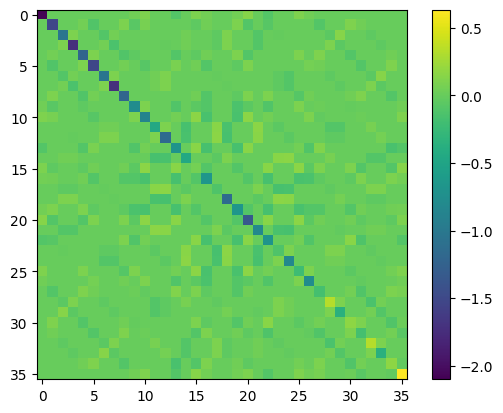

In [11]:
import matplotlib.pyplot as plt
plt.imshow(ham);
plt.colorbar()